In this notebook, I will be using the data I worked on in the previous NBA season to see if I can find trends in how player price increases relative to player value.<br><br>
Basically, I want to see if i can find the expected price change the next game for a player, based on how valuable they were that previous game.<br>
An example of finding this out would be being able to guess player A's price in game 2, based on his value in game 1.

In [1]:
#pulling in all the necessary python libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from scipy.stats import zscore
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
#create frame from saved csv of table I scraped and cleaned from RotoGuru1
tight_frame = pd.read_csv('tight_frame.csv')
#rename columns
tight_frame.columns = (['Row', 'Date', 'Position', 'Name', 'Fanduel_Points',
       'Fanduel_Price', 'Team', 'Score', 'Minutes_Played', 'Home', 'Foe',
       'Points', 'Rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers',
       '3pts', 'Field_Goals_Made', 'Field_Goals_Attempted', 'Shooting%',
       'Free_Throws_Made', 'Free_Throws_Attempted', 'Free_Throw%'])
#I am making a data frame with most of the scores
#but ignoring zeroes for now since that means someone scored zero points and most likely did not play

In [3]:
#moving names to front column and changing frame name to avoid accidentally saving over the other one
#since I use tight_frame in the other notebook too
player_frame = tight_frame[['Name','Date', 'Position', 'Fanduel_Points',
       'Fanduel_Price', 'Team', 'Score', 'Minutes_Played', 'Home', 'Foe',
       'Points', 'Rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers',
       '3pts', 'Field_Goals_Made', 'Field_Goals_Attempted', 'Shooting%',
       'Free_Throws_Made', 'Free_Throws_Attempted', 'Free_Throw%']].reset_index(drop=True)
#changing date column to date time
player_frame['Date'] =  pd.to_datetime(player_frame['Date'])
#creating a column with expected points scored based on price accoridng to Fanduel's value calculation
player_frame['Fanduel_Expected_Points'] = player_frame['Fanduel_Price'].apply(lambda x: round (x/1000,1))
#creating a column with Fanduel's value multiplier
player_frame['Fanduel_multiple'] = (player_frame['Fanduel_Points']/player_frame['Fanduel_Expected_Points'])
#removing all Zeros of fanduel multiple since it means somebody didn't play
no_zeros = player_frame[player_frame['Fanduel_multiple'] != 0].reset_index(drop=True)

In [4]:
#filtering for just the NBA 2020 season
#I discovered that my data cleaning had pulled information from both the 2018-2019 season and from the playoffs,
#which I do not want, so I'm pulling those out here
no_zeros['Date'] = pd.to_datetime(no_zeros['Date'])
#setting dates for Oct 22 2019 and March 10 2020 which is when the season began and then when the season shut down due to COVID
start_date = '10-22-2019'
end_date = '3-10-2020'
#creating filtered column of those dates
no_zeros['mask'] = (no_zeros['Date'] >= start_date) & (no_zeros['Date'] <= end_date)
#now I'm filtering for dates in this season
multiples = no_zeros[no_zeros['mask'] != False].reset_index(drop=True)
#making sure any empty statistical columns for a game are a zero and not a NaN
multiples = multiples.fillna(0)

In [5]:
#create a version of this series grouped by player name and date
#creating series that has player and date with Fanduel points
player_points = multiples.groupby(['Name','Date']).Fanduel_Points.mean()
#creating series that has player and date with Price
player_price = multiples.groupby(['Name','Date']).Fanduel_Price.mean()
#creating series that has player and date with Expected Points
player_expValue = multiples.groupby(['Name','Date']).Fanduel_Expected_Points.mean()
#creating series that has player and date with Value
player_RealValue = multiples.groupby(['Name','Date']).Fanduel_multiple.mean()
#creating series that has player and date with Minutes
player_minutes = multiples.groupby(['Name','Date']).Minutes_Played.mean()
#creating series that has player and date with Points
player_realpoints = multiples.groupby(['Name','Date']).Points.mean()
#creating series that has player and date with Rebounds
player_rebounds = multiples.groupby(['Name','Date']).Rebounds.mean()
#creating series that has player and date with Assists
player_assists = multiples.groupby(['Name','Date']).Assists.mean()
#creating series that has player and date with Steals
player_steals = multiples.groupby(['Name','Date']).Steals.mean()
#creating series that has player and date with Blocks
player_blocks = multiples.groupby(['Name','Date']).Blocks.mean()
#creating series that has player and date with Turnovers
player_turnovers = multiples.groupby(['Name','Date']).Turnovers.mean()
#creating series that has player and date with 3pts
player_3pts = multiples.groupby(['Name','Date'])['3pts'].mean()
#creating series that has player and date with shots made
player_fgs = multiples.groupby(['Name','Date']).Field_Goals_Made.mean()
#creating series that has player and date with shots attempted
player_fgas = multiples.groupby(['Name','Date']).Field_Goals_Attempted.mean()
#creating series that has player and date with shooting %
player_shooting = multiples.groupby(['Name','Date'])['Shooting%'].mean()
#creating series that has player and date with free throws made
player_ftm = multiples.groupby(['Name','Date']).Free_Throws_Made.mean()
#creating series that has player and date with free throws attempted
player_fta = multiples.groupby(['Name','Date']).Free_Throws_Attempted.mean()
#creating series that has player and date with free throws %
player_ftp = multiples.groupby(['Name','Date'])['Free_Throw%'].mean()
#concat into one table
player_table = pd.concat([player_points,player_expValue,player_RealValue,\
                        player_price,player_minutes,player_realpoints,player_rebounds,player_assists,player_steals,\
                         player_blocks,player_turnovers,player_3pts,player_fgs,player_fgas,player_shooting,player_ftm,\
                         player_fta,player_ftp],axis=1).reset_index()

In [6]:
#Creating a Column Previous Value that will contain the value provided by the player in their last game
#for now, it will have their value for that specific week
player_table['Prev_Value'] = player_table['Fanduel_multiple']
#adding whether a game was Home as a 1 or Away as a 0 since Fanduel claims to account for it in determining price
player_table['Home'] = multiples['Home'].apply(lambda x: 1 if str(x) == 'Home' else 0)

In [7]:
#I am also now going to remove any player who appears less than 5 times
#If somebody only played 5 games this season, I am just not interested in them and do not want them to throw off my numbers
trimmedplayer_table = player_table.groupby('Name').filter(lambda x : len(x)>4).reset_index(drop=True)

In [8]:
#now, I have my table in order by players and then by dates. I want to write a loop that will check for a players name 
#if it is the same as the previous row, it will place the previous week's value
#if it is a new name, it place the player's value they scored that week
#Creating list with just the first value
Result = [2.767123]
#writing comprehension to update previous value after checking on name change
def prev_value(df):
    #loop checking if name changes
    for i in range(1,len(df)):
        #if name for new row matches name for last row, then list value from last row
        if df.Name[i] == df.Name[i-1]:
            Result.append(df.Fanduel_multiple[i-1])
        #if name for new row does not match name for last row, then use value from that game
        elif df.Name[i] != df.Name[i-1]:
            Result.append(df.Fanduel_multiple[i])
#running comprehnesion to create list of previous values
prev_value(trimmedplayer_table)
#adding that list to my frame as a new column
trimmedplayer_table['Prev_Value'] = Result

#Repeating this for price and for points

#Points first
Points = [20.2]
#writing comprehension to update previous points after checking on name change
def prev_points(df):
    #loop checking if name changes
    for i in range(1,len(df)):
        #if name for new row matches name for last row, then list value from last row
        if df.Name[i] == df.Name[i-1]:
            Points.append(df.Fanduel_Points[i-1])
        #if name for new row does not match name for last row, then use value from that game
        elif df.Name[i] != df.Name[i-1]:
            Points.append(df.Fanduel_Points[i])
#running comprehnesion to create list of previous values
prev_points(trimmedplayer_table)
#adding that list to my frame as a new column
trimmedplayer_table['Prev_FDPoints'] = Points
#Now Price
Price = [7300]
#writing comprehension to update previous points after checking on name change
def prev_price(df):
    #loop checking if name changes
    for i in range(1,len(df)):
        #if name for new row matches name for last row, then list value from last row
        if df.Name[i] == df.Name[i-1]:
            Price.append(df.Fanduel_Price[i-1])
        #if name for new row does not match name for last row, then use value from that game
        elif df.Name[i] != df.Name[i-1]:
            Price.append(df.Fanduel_Price[i])
#running comprehension to create list of previous values
prev_price(trimmedplayer_table)
#adding that list to my frame as a new column
trimmedplayer_table['Prev_Price'] = Price

In addition to just the previous score, I am going to add a three game rolling average and 5 game rolling average for Value, Points, and Stats to see if those have a any stronger correlation to price.

In [9]:
#now, I'd like to add a rolling average for each as well so we are using more than just the previous day's performance
#3 day rolling average of value
trimmedplayer_table['3_Game_Value']=trimmedplayer_table.groupby('Name').Prev_Value.apply(lambda x : x.shift().rolling(3,min_periods=1).mean().fillna(x))
#3 day rolling average of Fanduel Points
trimmedplayer_table['3_Game_FDPoints']=trimmedplayer_table.groupby('Name').Prev_FDPoints.apply(lambda x : x.shift().rolling(3,min_periods=1).mean().fillna(x))
#3 day rolling average of Price
trimmedplayer_table['3_Game_Price']=trimmedplayer_table.groupby('Name').Prev_Price.apply(lambda x : x.shift().rolling(3,min_periods=1).mean().fillna(x))
#5 day rolling average of value
trimmedplayer_table['5_Game_Value']=trimmedplayer_table.groupby('Name').Prev_Value.apply(lambda x : x.shift().rolling(5,min_periods=1).mean().fillna(x))
#10 day rolling average of value
trimmedplayer_table['10_Game_Value']=trimmedplayer_table.groupby('Name').Prev_Value.apply(lambda x : x.shift().rolling(10,min_periods=1).mean().fillna(x))
#15 day rolling average of value
trimmedplayer_table['15_Game_Value']=trimmedplayer_table.groupby('Name').Prev_Value.apply(lambda x : x.shift().rolling(15,min_periods=1).mean().fillna(x))
#5 day rolling average of Fanduel Points
trimmedplayer_table['5_Game_FDPoints']=trimmedplayer_table.groupby('Name').Prev_FDPoints.apply(lambda x : x.shift().rolling(5,min_periods=1).mean().fillna(x))
#5 day rolling average of Price
trimmedplayer_table['5_Game_Price']=trimmedplayer_table.groupby('Name').Prev_Price.apply(lambda x : x.shift().rolling(5,min_periods=1).mean().fillna(x))
#3 day rolling average of Minutes
trimmedplayer_table['3_Game_Minutes']=trimmedplayer_table.groupby('Name').Minutes_Played.apply(lambda x : x.shift().rolling(3,min_periods=1).mean().fillna(x))
#5 day rolling average of Minutes
trimmedplayer_table['5_Game_Minutes']=trimmedplayer_table.groupby('Name').Minutes_Played.apply(lambda x : x.shift().rolling(5,min_periods=1).mean().fillna(x))
#3 day rolling average of Points
trimmedplayer_table['3_Game_Points']=trimmedplayer_table.groupby('Name').Points.apply(lambda x : x.shift().rolling(3,min_periods=1).mean().fillna(x))
#5 day rolling average of Points
trimmedplayer_table['5_Game_Points']=trimmedplayer_table.groupby('Name').Points.apply(lambda x : x.shift().rolling(5,min_periods=1).mean().fillna(x))
#10 day rolling average of Points
trimmedplayer_table['10_Game_Points']=trimmedplayer_table.groupby('Name').Points.apply(lambda x : x.shift().rolling(10,min_periods=1).mean().fillna(x))
#15 day rolling average of Points
trimmedplayer_table['15_Game_Points']=trimmedplayer_table.groupby('Name').Points.apply(lambda x : x.shift().rolling(15,min_periods=1).mean().fillna(x))
#3 day rolling average of Rebounds
trimmedplayer_table['3_Game_Rebounds']=trimmedplayer_table.groupby('Name').Points.apply(lambda x : x.shift().rolling(3,min_periods=1).mean().fillna(x))
#5 day rolling average of Rebounds
trimmedplayer_table['5_Game_Rebounds']=trimmedplayer_table.groupby('Name').Points.apply(lambda x : x.shift().rolling(5,min_periods=1).mean().fillna(x))
#10 day rolling average of Rebounds
trimmedplayer_table['10_Game_Rebounds']=trimmedplayer_table.groupby('Name').Points.apply(lambda x : x.shift().rolling(10,min_periods=1).mean().fillna(x))
#15 day rolling average of Rebounds
trimmedplayer_table['15_Game_Rebounds']=trimmedplayer_table.groupby('Name').Points.apply(lambda x : x.shift().rolling(15,min_periods=1).mean().fillna(x))
#3 day rolling average of Assists
trimmedplayer_table['3_Game_Assists']=trimmedplayer_table.groupby('Name').Assists.apply(lambda x : x.shift().rolling(3,min_periods=0).mean().fillna(x))
#5 day rolling average of Assists
trimmedplayer_table['5_Game_Assists']=trimmedplayer_table.groupby('Name').Assists.apply(lambda x : x.shift().rolling(5,min_periods=0).mean().fillna(x))
#10 day rolling average of Assists
trimmedplayer_table['10_Game_Assists']=trimmedplayer_table.groupby('Name').Assists.apply(lambda x : x.shift().rolling(10,min_periods=0).mean().fillna(x))
#15 day rolling average of Assists
trimmedplayer_table['15_Game_Assists']=trimmedplayer_table.groupby('Name').Assists.apply(lambda x : x.shift().rolling(15,min_periods=0).mean().fillna(x))
#3 day rolling average of Steals
trimmedplayer_table['3_Game_Steals']=trimmedplayer_table.groupby('Name').Steals.apply(lambda x : x.shift().rolling(3,min_periods=0).mean().fillna(x))
#5 day rolling average of Steals
trimmedplayer_table['5_Game_Steals']=trimmedplayer_table.groupby('Name').Steals.apply(lambda x : x.shift().rolling(5,min_periods=0).mean().fillna(x))
#10 day rolling average of Steals
trimmedplayer_table['10_Game_Steals']=trimmedplayer_table.groupby('Name').Steals.apply(lambda x : x.shift().rolling(10,min_periods=0).mean().fillna(x))
#15 day rolling average of Steals
trimmedplayer_table['15_Game_Steals']=trimmedplayer_table.groupby('Name').Steals.apply(lambda x : x.shift().rolling(15,min_periods=0).mean().fillna(x))
#3 day rolling average of Blocks
trimmedplayer_table['3_Game_Blocks']=trimmedplayer_table.groupby('Name').Blocks.apply(lambda x : x.shift().rolling(3,min_periods=0).mean().fillna(x))
#5 day rolling average of Blocks
trimmedplayer_table['5_Game_Blocks']=trimmedplayer_table.groupby('Name').Blocks.apply(lambda x : x.shift().rolling(5,min_periods=0).mean().fillna(x))
#10 day rolling average of Blocks
trimmedplayer_table['10_Game_Blocks']=trimmedplayer_table.groupby('Name').Blocks.apply(lambda x : x.shift().rolling(10,min_periods=0).mean().fillna(x))
#15 day rolling average of Blocks
trimmedplayer_table['15_Game_Blocks']=trimmedplayer_table.groupby('Name').Blocks.apply(lambda x : x.shift().rolling(15,min_periods=0).mean().fillna(x))
#3 day rolling average of Steals
trimmedplayer_table['3_Game_Turnovers']=trimmedplayer_table.groupby('Name').Turnovers.apply(lambda x : x.shift().rolling(3,min_periods=0).mean().fillna(x))
#5 day rolling average of Steals
trimmedplayer_table['5_Game_Turnovers']=trimmedplayer_table.groupby('Name').Turnovers.apply(lambda x : x.shift().rolling(5,min_periods=0).mean().fillna(x))
#10 day rolling average of Steals
trimmedplayer_table['10_Game_Turnovers']=trimmedplayer_table.groupby('Name').Turnovers.apply(lambda x : x.shift().rolling(10,min_periods=0).mean().fillna(x))
#15 day rolling average of Steals
trimmedplayer_table['15_Game_Turnovers']=trimmedplayer_table.groupby('Name').Turnovers.apply(lambda x : x.shift().rolling(15,min_periods=0).mean().fillna(x))
#3 day rolling average of 3pts
trimmedplayer_table['3_Game_3pts']=trimmedplayer_table.groupby('Name')['3pts'].apply(lambda x : x.shift().rolling(3,min_periods=0).mean().fillna(x))
#5 day rolling average of 3pts
trimmedplayer_table['5_Game_3pts']=trimmedplayer_table.groupby('Name')['3pts'].apply(lambda x : x.shift().rolling(5,min_periods=0).mean().fillna(x))
#10 day rolling average of 3pts
trimmedplayer_table['10_Game_3pts']=trimmedplayer_table.groupby('Name')['3pts'].apply(lambda x : x.shift().rolling(10,min_periods=0).mean().fillna(x))
#15 day rolling average of 3pts
trimmedplayer_table['15_Game_3pts']=trimmedplayer_table.groupby('Name')['3pts'].apply(lambda x : x.shift().rolling(15,min_periods=0).mean().fillna(x))
#3 day rolling average of Shooting %
trimmedplayer_table['3_Game_Shooting']=trimmedplayer_table.groupby('Name')['Shooting%'].apply(lambda x : x.shift().rolling(3,min_periods=0).mean().fillna(x))
#5 day rolling average of Shooting %
trimmedplayer_table['5_Game_Shooting']=trimmedplayer_table.groupby('Name')['Shooting%'].apply(lambda x : x.shift().rolling(5,min_periods=0).mean().fillna(x))
#10 day rolling average of Shooting%
trimmedplayer_table['10_Game_Shooting']=trimmedplayer_table.groupby('Name')['Shooting%'].apply(lambda x : x.shift().rolling(10,min_periods=0).mean().fillna(x))
#15 day rolling average of Shooting%
trimmedplayer_table['15_Game_Shooting']=trimmedplayer_table.groupby('Name')['Shooting%'].apply(lambda x : x.shift().rolling(15,min_periods=0).mean().fillna(x))
#3 day rolling average of Free_Throw%
trimmedplayer_table['3_Game_FreeThrowP']=trimmedplayer_table.groupby('Name')['Free_Throw%'].apply(lambda x : x.shift().rolling(3,min_periods=0).mean().fillna(x))
#5 day rolling average of Free_Throw%
trimmedplayer_table['5_Game_FreeThrowP']=trimmedplayer_table.groupby('Name')['Free_Throw%'].apply(lambda x : x.shift().rolling(5,min_periods=0).mean().fillna(x))
#10 day rolling average of Free_Throw%
trimmedplayer_table['10_Game_FreeThrowP']=trimmedplayer_table.groupby('Name')['Free_Throw%'].apply(lambda x : x.shift().rolling(10,min_periods=0).mean().fillna(x))
#15 day rolling average of Free_Throw%
trimmedplayer_table['15_Game_FreeThrowP']=trimmedplayer_table.groupby('Name')['Free_Throw%'].apply(lambda x : x.shift().rolling(15,min_periods=0).mean().fillna(x))
#3 day rolling average of Free Throws Made
trimmedplayer_table['3_Game_FreeThrowsMade']=trimmedplayer_table.groupby('Name').Free_Throws_Made.apply(lambda x : x.shift().rolling(3,min_periods=0).mean().fillna(x))
#5 day rolling average of Free Throws Made
trimmedplayer_table['5_Game_FreeThrowsMade']=trimmedplayer_table.groupby('Name').Free_Throws_Made.apply(lambda x : x.shift().rolling(5,min_periods=0).mean().fillna(x))
#10 day rolling average of free Throws Made
trimmedplayer_table['10_Game_FTM']=trimmedplayer_table.groupby('Name').Free_Throws_Made.apply(lambda x : x.shift().rolling(10,min_periods=1).mean().fillna(x))
#15 day rolling average of Free Throws Made
trimmedplayer_table['15_Game_FTM']=trimmedplayer_table.groupby('Name').Free_Throws_Made.apply(lambda x : x.shift().rolling(15,min_periods=1).mean().fillna(x))
#3 day rolling average of Free_Throws_Attempted
trimmedplayer_table['3_Game_Free_Throws_Attempted']=trimmedplayer_table.groupby('Name').Free_Throws_Attempted.apply(lambda x : x.shift().rolling(3,min_periods=0).mean().fillna(x))
#5 day rolling average of Steals
trimmedplayer_table['5_Game_Free_Throws_Attempted']=trimmedplayer_table.groupby('Name').Free_Throws_Attempted.apply(lambda x : x.shift().rolling(5,min_periods=1).mean().fillna(x))
#10 day rolling average of Steals
trimmedplayer_table['10_Game_Free_Throws_Attempted']=trimmedplayer_table.groupby('Name').Free_Throws_Attempted.apply(lambda x : x.shift().rolling(10,min_periods=1).mean().fillna(x))
#15 day rolling average of Steals
trimmedplayer_table['15_Game_Free_Throws_Attempted']=trimmedplayer_table.groupby('Name').Free_Throws_Attempted.apply(lambda x : x.shift().rolling(15,min_periods=1).mean().fillna(x))

Now that I have my columns set up, I'm going to try to see if we can set up a model to project a player's price based on their previous scores. We can then compare it to a test sample to see how close we get.

In [10]:
#printing average value to keep it in mind as a baseline
print('Mean value: ' + str(trimmedplayer_table.Fanduel_multiple.mean()))
print('Median value: ' + str(trimmedplayer_table.Fanduel_multiple.median()))
#using .corr() to eyeball how certain factors seem to line up
trimmedplayer_table.corr()

Mean value: 4.242784400490812
Median value: 4.182795698924731


,Fanduel_Points,Fanduel_Expected_Points,Fanduel_multiple,Fanduel_Price,Minutes_Played,Points,Rebounds,Assists,Steals,Blocks,...,10_Game_FreeThrowP,15_Game_FreeThrowP,3_Game_FreeThrowsMade,5_Game_FreeThrowsMade,10_Game_FTM,15_Game_FTM,3_Game_Free_Throws_Attempted,5_Game_Free_Throws_Attempted,10_Game_Free_Throws_Attempted,15_Game_Free_Throws_Attempted
Fanduel_Points,1.000000,0.700469,0.788793,0.700469,0.768378,0.872674,0.650049,0.603193,0.454333,0.360703,...,0.449667,0.462905,0.501342,0.541246,0.571518,0.581081,0.535814,0.568374,0.592933,0.599624
Fanduel_Expected_Points,0.700469,1.000000,0.167313,1.000000,0.599604,0.644821,0.488100,0.510456,0.218804,0.199138,...,0.530393,0.547246,0.652190,0.704206,0.745725,0.758583,0.720010,0.764164,0.797036,0.806140
Fanduel_multiple,0.788793,0.167313,1.000000,0.167313,0.615155,0.655112,0.499853,0.404049,0.447918,0.330017,...,0.213092,0.219097,0.170373,0.181889,0.191205,0.195041,0.160299,0.167425,0.174401,0.176327
Fanduel_Price,0.700469,1.000000,0.167313,1.000000,0.599604,0.644821,0.488100,0.510456,0.218804,0.199138,...,0.530393,0.547246,0.652190,0.704206,0.745725,0.758583,0.720010,0.764164,0.797036,0.806140
Minutes_Played,0.768378,0.599604,0.615155,0.599604,1.000000,0.706608,0.500714,0.505722,0.330286,0.188970,...,0.471600,0.482107,0.461215,0.491111,0.513478,0.519514,0.455020,0.476567,0.492485,0.495374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_Game_FTM,0.581081,0.758583,0.195041,0.758583,0.519514,0.591711,0.330411,0.431799,0.168863,0.108454,...,0.782091,0.811715,0.837654,0.911107,0.977569,1.000000,0.797933,0.851559,0.897868,0.912426
3_Game_Free_Throws_Attempted,0.535814,0.720010,0.160299,0.720010,0.455020,0.537208,0.321124,0.393341,0.157129,0.113198,...,0.564907,0.562737,0.876263,0.839273,0.809520,0.797933,1.000000,0.939740,0.891810,0.875204
5_Game_Free_Throws_Attempted,0.568374,0.764164,0.167425,0.764164,0.476567,0.569883,0.339764,0.418365,0.166588,0.120761,...,0.603507,0.601346,0.823998,0.892290,0.864026,0.851559,0.939740,1.000000,0.951317,0.933543
10_Game_Free_Throws_Attempted,0.592933,0.797036,0.174401,0.797036,0.492485,0.594330,0.354280,0.437235,0.169973,0.127548,...,0.631484,0.633256,0.783146,0.849786,0.907389,0.897868,0.891810,0.951317,1.000000,0.983786


Looking at this table, it seems like we may not see too much of a correlation in our model, but let's play it out

In [11]:
#Creating a frame of all my factors I want to weigh in to how price is calculated
X = trimmedplayer_table[['Prev_Value','Home','Prev_FDPoints','3_Game_Value', '3_Game_FDPoints','5_Game_Value',\
                         '5_Game_FDPoints', '3_Game_Minutes','5_Game_Minutes','10_Game_Value','15_Game_Value',\
                         '3_Game_Minutes','5_Game_Minutes', '3_Game_Points','5_Game_Points',\
                           '10_Game_Points', '15_Game_Points', '3_Game_Rebounds','5_Game_Rebounds','10_Game_Rebounds',\
                         '15_Game_Rebounds', '3_Game_Free_Throws_Attempted','5_Game_Free_Throws_Attempted',\
                         '10_Game_Free_Throws_Attempted','15_Game_Free_Throws_Attempted','3_Game_FreeThrowsMade', '5_Game_FreeThrowsMade',\
                         '10_Game_FTM','15_Game_FTM','3_Game_Blocks', '5_Game_Blocks', '10_Game_Blocks','15_Game_Blocks',\
                         '3_Game_Steals', '5_Game_Steals', '10_Game_Steals','15_Game_Steals','3_Game_Turnovers',\
                         '5_Game_Turnovers','3_Game_Assists', '5_Game_Assists','10_Game_Assists','15_Game_Assists',\
                         '10_Game_Turnovers', '15_Game_Turnovers', '3_Game_3pts','5_Game_3pts','10_Game_3pts',\
                         '15_Game_3pts', '3_Game_Shooting', '5_Game_Shooting','10_Game_Shooting', '15_Game_Shooting',\
                         '3_Game_FreeThrowP','5_Game_FreeThrowP','10_Game_FreeThrowP', '15_Game_FreeThrowP']]
#creating frame of prices as my dependent variable
y = trimmedplayer_table['Fanduel_Price']
#Creating test split and train split
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=6)
#creating variable for linear regression method
lm = LinearRegression()
##creating model based on my training split of the data I have pulled
model = lm.fit(x_train, y_train)
##creating a set of y predictions from my test content
y_predict= lm.predict(x_test)
##scoring of model based just on my training
print("Train score:")
print(lm.score(x_train, y_train))
##scoring of my model with test content
print("Test score:")
print(lm.score(x_test, y_test))

Train score:
0.9523436293203094
Test score:
0.9520788186437992


The scores to guess price actually look fairly good once we apply them! I'm going to plot the test here to get a visual.

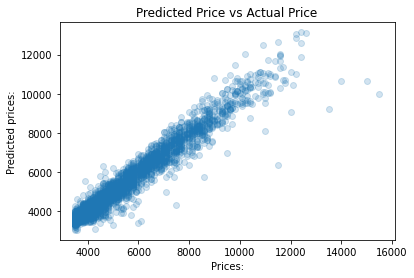

In [12]:
#creating scatter plot comparing my test values
plt.scatter(y_test, y_predict, alpha=.2)

plt.xlabel("Prices:")
plt.ylabel("Predicted prices:")
plt.title("Predicted Price vs Actual Price")

plt.show()

Looking at the plot, it seems like my model has an issue where it is slightly more likely to undervalue a player compared to the price chosen by Fanduel.

Now I want to do something similar for Value. 

In [13]:
#Creating a frame of all my factors I want to weigh in to how value is calculated
X2 = trimmedplayer_table[['Fanduel_Price','5_Game_FDPoints', '5_Game_Minutes','Home']]
#creating frame of prices as my dependent variable
y2 = trimmedplayer_table['Fanduel_multiple']
#Creating test split and train split
x2_train, x2_test, y2_train, y2_test = train_test_split(X2, y2, train_size = 0.8, test_size = 0.2, random_state=6)
#creating variable for linear regression method
lm2 = LinearRegression()
#creating model based on my training split of the data I have pulled
model2 = lm2.fit(x2_train, y2_train)
#creating a set of y predictions from my test content
y2_predict= lm2.predict(x2_test)
#scoring of model based just on my training
print("Train score:")
print(lm2.score(x2_train, y2_train))
#scoring of my model with test content
print("Test score:")
print(lm2.score(x2_test, y2_test))

Train score:
0.10939792986554797
Test score:
0.12228817264834746


y=0.115492x+(3.758239)


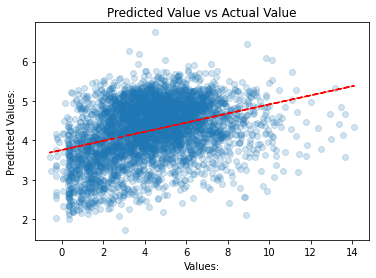

In [14]:
#scores are brutal. Let's plot and see if there is a pattern to our incorrect prediction.
#creating scatter plot comparing my test values
plt.scatter(y2_test, y2_predict, alpha=.2)
plt.plot()

plt.xlabel("Values:")
plt.ylabel("Predicted Values:")
plt.title("Predicted Value vs Actual Value")
# calc the trendline to see if most seem to be over or under
z = np.polyfit(y2_test, y2_predict, 1)
p = np.poly1d(z)
plt.plot(y2_test,p(y2_test),"r--")
# the line equation:
print("y=%.6fx+(%.6f)"%(z[0],z[1]))

plt.show()
#seems like we are really getting thrown off by high performers
#While there are a bunch of actual values 6+, our model has almost none

It looks like our model is currently no good for predicting value. Next steps would be looking at an alternative form of modeling such as logistical regression.

In [15]:
#putting all of my factors into a list
x_factors = ['Fanduel_Price','Prev_Price','Prev_FDPoints','Prev_Value','3_Game_Price', '3_Game_FDPoints',\
                          '5_Game_Value','5_Game_FDPoints', '3_Game_Minutes','5_Game_Minutes','5_Game_Price','10_Game_Value',\
                          '15_Game_Value','5_Game_Price','3_Game_Minutes','5_Game_Minutes', '3_Game_Points','5_Game_Points',\
                          '10_Game_Points', '15_Game_Points','3_Game_Rebounds','5_Game_Rebounds','10_Game_Rebounds',\
                          '15_Game_Rebounds','3_Game_Free_Throws_Attempted','5_Game_Free_Throws_Attempted','10_Game_Free_Throws_Attempted',\
                          '15_Game_Free_Throws_Attempted','3_Game_FreeThrowsMade', '5_Game_FreeThrowsMade',\
                         '10_Game_FTM','15_Game_FTM','3_Game_Blocks', '5_Game_Blocks', '10_Game_Blocks','15_Game_Blocks',\
                         '3_Game_Steals', '5_Game_Steals', '10_Game_Steals','15_Game_Steals','3_Game_Assists', '5_Game_Assists','10_Game_Assists','15_Game_Assists',\
                         '3_Game_3pts','5_Game_3pts','10_Game_3pts','15_Game_3pts', '3_Game_Shooting', '5_Game_Shooting',\
                          '10_Game_Shooting', '15_Game_Shooting','3_Game_FreeThrowP','5_Game_FreeThrowP','10_Game_FreeThrowP', '15_Game_FreeThrowP']

In [17]:
#Creating a frame of all my factors I want to weigh in to how points are calculated
X3 = trimmedplayer_table[x_factors]
#creating frame of prices as my dependent variable
y3 = trimmedplayer_table['Fanduel_Points']
#Creating test split and train split
x3_train, x3_test, y3_train, y3_test = train_test_split(X3, y3, train_size = 0.8, test_size = 0.2, random_state=6)
#creating variable for linear regression method
lm3 = LinearRegression()
#creating model based on my training split of the data I have pulled
model3 = lm3.fit(x3_train, y3_train)
#creating a set of y predictions from my test content
y3_predict= lm3.predict(x3_test)
#scoring of model based just on my training
print("Train score:")
print(lm3.score(x3_train, y3_train))
#scoring of my model with test content
print("Test score:")
print(lm3.score(x3_test, y3_test))

Train score:
0.5418730173071117
Test score:
0.5319870021845146


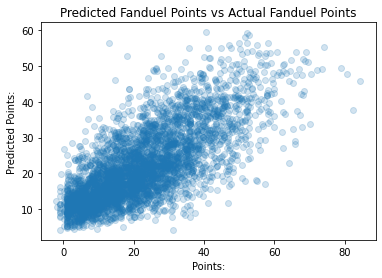

In [18]:
##scores remain poor. Let's plot and see if there is a pattern to our incorrect prediction.
#creating scatter plot comparing my test values
plt.scatter(y3_test, y3_predict, alpha=.2)
plt.plot()

plt.xlabel("Points:")
plt.ylabel("Predicted Points:")
plt.title("Predicted Fanduel Points vs Actual Fanduel Points")
plt.show()

Although this is more consistent than our value, it still isn't great. It looks like there are lots of cases where players scored significantly more fanduel points than predicted, which is likely wha'ts throwing off our score. I'd also love to see which two player/game combos were projected to score 55 Fanduel points and got less than 20 to see if the player(s) were injured.<br> Looking at all three of these, it looks like we're good at guessing price but bad at guessing points, which leads to a bigger issue when we have to guess both.<br><br>

I'm now going to try a few other forms of modeling to see if any of them are more accurate. I'll primarily focus on value since that is the key to fanduel success. I'd like to be able to use all of the rolling averages, but since they're related I don't want to just use a simple regression model. Some online research indicates an ElasticNet model could help.

In [22]:
#Restating a frame of all my factors I want to weigh in to how value is calculated. 
X4 = trimmedplayer_table[x_factors]
#creating frame of prices as my dependent variable
y4 = trimmedplayer_table['Fanduel_multiple']
#importing ridge model
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
#creating variable for linear regression method
lm4 = ElasticNet(random_state=6)
#Creating test split and train split
x4_train, x4_test, y4_train, y4_test = train_test_split(X4, y4, train_size = 0.8, test_size = 0.2, random_state=6)
#creating model based on my training split of the data I have pulled
model4 = lm4.fit(x4_train, y4_train)
#creating a set of y predictions from my test content
y4_predict= lm4.predict(x4_test)
#scoring of model based just on my training
print("Train score:")
print(lm4.score(x4_train, y4_train))
#scoring of my model with test content
print("Test score:")
print(lm4.score(x4_test, y4_test))

Train score:
0.12487784921563139
Test score:
0.1348877555968715


I'm going to see if we can do any kind of categorical evaluation of value. We will go ahead an create a new column called 'Valuable' that will assign a 1 if a player had a game with a value greater than 4.2 (the Fanduel average) and a zero if less. We will then see if we can use a random forest model to discover a way to predict if a player will be more valuable than average or not.

In [20]:
#adding column to my frame that gives a 1 or 0 if Fanduel_multiple exceeds the average
trimmedplayer_table['Valuable'] = trimmedplayer_table['Fanduel_multiple'].apply(lambda x: 1 if x > 4.3 else 0)

In [21]:
#creating my random forest classifier
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 2000, random_state=0)
#Restating a frame of all my factors I want to weigh in to how value is calculated. 
X5 = trimmedplayer_table[x_factors]
#creating frame of prices as my dependent variable
y5 = trimmedplayer_table['Valuable']
#Creating test split and train split
x5_train, x5_test, y5_train, y5_test = train_test_split(X5, y5, train_size = 0.8, test_size = 0.2, random_state=6)
#fitting my classifier
classifier.fit(x5_train,y5_train)

RandomForestClassifier(n_estimators=2000, random_state=0)

In [23]:
classifier.score(x5_test,y5_test)

0.6262013151239252

considering that I split my value right on the average score, it's not great that our predictor is only slightly better than 50% - I feel like we could get there just by not choosing players who we know will not play very much